
# Directed Acyclic Graphs (DAG) — Python Demos and Blockchain Context

This notebook has two parts:

1. **Core DAG demo** — build a small DAG, validate that it’s acyclic, perform a topological sort, and visualize it with arrows.
2. **Blockchain context** — a minimal **DAG ledger** simulation inspired by Tangle-like ideas where each new transaction references two prior "tips". We visualize the resulting transaction graph and a few simple metrics.

> Run cells top-to-bottom. Plots use only `matplotlib` (no seaborn) and each figure is rendered in its own cell.


In [1]:

from collections import defaultdict, deque
import random
import math
import time

import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch, Circle
from matplotlib.collections import PatchCollection

random.seed(7)



## Part 1 — A Minimal DAG Implementation

We implement a tiny DAG helper with:
- `add_edge(u, v)`: add a directed edge u → v
- `has_cycle()`: cycle detection (DFS/white-gray-black)
- `topological_sort()`: Kahn’s algorithm
- `layers()`: level assignment from in-degree (useful for a simple layout)
- `draw()`: quick `matplotlib` visualization


In [2]:

class SimpleDAG:
    def __init__(self):
        self.adj = defaultdict(list)
        self.nodes_set = set()
    
    def add_edge(self, u, v):
        self.adj[u].append(v)
        self.nodes_set.add(u)
        self.nodes_set.add(v)
    
    def nodes(self):
        return sorted(self.nodes_set)
    
    def has_cycle(self):
        # 0 = unvisited, 1 = in-stack (gray), 2 = done (black)
        color = {u:0 for u in self.nodes_set}
        
        def dfs(u):
            color[u] = 1
            for v in self.adj[u]:
                if color[v] == 1:
                    return True
                if color[v] == 0 and dfs(v):
                    return True
            color[u] = 2
            return False
        
        for u in list(self.nodes_set):
            if color[u] == 0:
                if dfs(u):
                    return True
        return False
    
    def topological_sort(self):
        indeg = {u:0 for u in self.nodes_set}
        for u in self.nodes_set:
            for v in self.adj[u]:
                indeg[v] += 1
        
        q = deque([u for u in self.nodes_set if indeg[u] == 0])
        order = []
        while q:
            u = q.popleft()
            order.append(u)
            for v in self.adj[u]:
                indeg[v] -= 1
                if indeg[v] == 0:
                    q.append(v)
        if len(order) != len(self.nodes_set):
            raise ValueError("Cycle detected (no valid topological order).")
        return order
    
    def layers(self):
        # Assign each node a "layer" equal to the length of the longest path from any source
        indeg = {u:0 for u in self.nodes_set}
        for u in self.nodes_set:
            for v in self.adj[u]:
                indeg[v] += 1
        layer = {u:0 for u in self.nodes_set}
        queue = deque([u for u in self.nodes_set if indeg[u] == 0])
        topo = []
        while queue:
            u = queue.popleft()
            topo.append(u)
            for v in self.adj[u]:
                layer[v] = max(layer[v], layer[u] + 1)
                indeg[v] -= 1
                if indeg[v] == 0:
                    queue.append(v)
        return layer
    
    def draw(self, figsize=(6,4)):
        # Simple layered layout from self.layers()
        layer = self.layers()
        by_layer = defaultdict(list)
        for u, L in layer.items():
            by_layer[L].append(u)
        
        pos = {}
        for L, nodes in by_layer.items():
            n = len(nodes)
            for i, u in enumerate(sorted(nodes)):
                # spread horizontally within layer using index; vertically by layer
                x = i - (n-1)/2.0
                y = -L
                pos[u] = (x, y)
        
        fig, ax = plt.subplots(figsize=figsize)
        patches = []
        
        # Draw edges as arrows
        for u in self.nodes_set:
            x1, y1 = pos[u]
            for v in self.adj[u]:
                x2, y2 = pos[v]
                arrow = FancyArrowPatch((x1, y1), (x2, y2),
                                        arrowstyle='->',
                                        mutation_scale=12,
                                        linewidth=1.5)
                ax.add_patch(arrow)
        
        # Draw nodes as circles with labels
        for u, (x, y) in pos.items():
            c = Circle((x, y), 0.15)
            patches.append(c)
            ax.text(x, y, str(u), ha='center', va='center', fontsize=10)
        
        pc = PatchCollection(patches, edgecolor='black', facecolor='white', linewidth=1.5)
        ax.add_collection(pc)
        
        ax.set_aspect('equal')
        ax.set_axis_off()
        plt.show()



### Build and Visualize a Sample DAG
We'll create a DAG with edges:
```
A → C, A → D, B → D, C → E, D → E, D → F
```


Nodes: ['A', 'B', 'C', 'D', 'E', 'F']
Cycle present? False
Topological order: ['B', 'A', 'C', 'D', 'E', 'F']


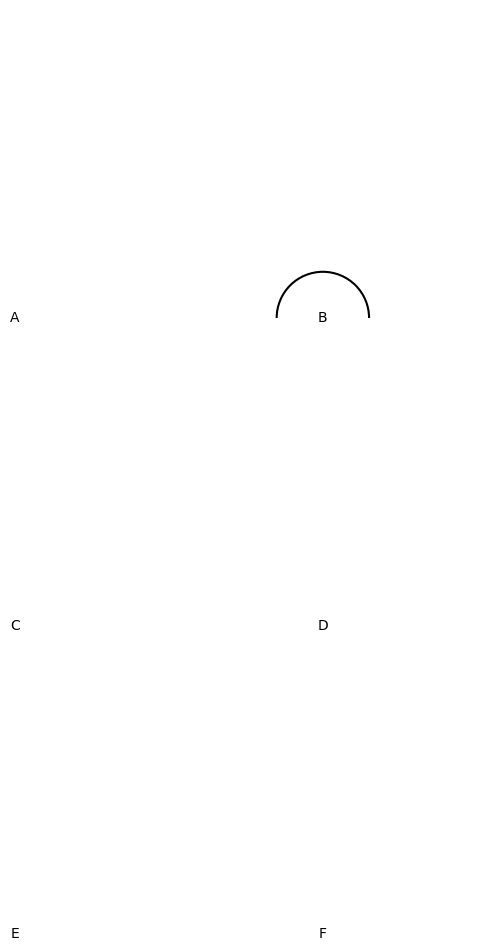

In [3]:

dag = SimpleDAG()
edges = [('A','C'), ('A','D'), ('B','D'), ('C','E'), ('D','E'), ('D','F')]
for u, v in edges:
    dag.add_edge(u, v)

print("Nodes:", dag.nodes())
print("Cycle present?", dag.has_cycle())
print("Topological order:", dag.topological_sort())

dag.draw(figsize=(7,4))



### (Optional) Cycle Check Demo
If we try to add an edge that creates a cycle, `has_cycle()` returns `True` and `topological_sort()` will fail.


In [4]:

# Create a new graph that intentionally has a cycle A->B->C->A
cyc = SimpleDAG()
cyc.add_edge('A','B')
cyc.add_edge('B','C')
cyc.add_edge('C','A')
print("Cycle present in cyc?", cyc.has_cycle())


Cycle present in cyc? True



## Part 2 — A Tiny DAG Ledger Simulation (Blockchain Context)

**Idea:** In some distributed ledger designs (e.g., Tangle-like DAGs), a new transaction/vertex references a couple of prior "tips" (unconfirmed transactions). This creates a **Directed Acyclic Graph** rather than a single longest chain.

This is a toy model that **omits** consensus, weights, security, and network details, but it helps visualize how a DAG ledger can *grow* when each new vertex approves two earlier tips.


In [5]:

class Tx:
    def __init__(self, tx_id, parents, t):
        self.id = tx_id
        self.parents = tuple(parents)
        self.time = t  # arrival index as time surrogate

class DAGLedgerSim:
    def __init__(self):
        self.transactions = {}     # id -> Tx
        self.children = defaultdict(list)
        self.tips = set()          # tx ids with no children yet
        self.roots = set()         # genesis-like
        self.counter = 0
        
        # add a genesis tx
        self.add_tx(parents=[])
    
    def add_tx(self, parents=None):
        if parents is None:
            parents = []
        tx_id = f"T{self.counter}"
        self.counter += 1
        tx = Tx(tx_id, parents, self.counter)
        self.transactions[tx_id] = tx
        
        if not parents:
            self.roots.add(tx_id)
        else:
            for p in parents:
                self.children[p].append(tx_id)
                if p in self.tips:
                    self.tips.remove(p)
        # new tx is initially a tip
        self.tips.add(tx_id)
        return tx_id
    
    def pick_parents(self, k=2):
        # pick k tips (or fallback to some existing txs) — simple uniform choice
        tips = list(self.tips)
        parents = []
        if len(tips) >= k:
            parents = random.sample(tips, k)
        else:
            # not enough tips; sample from all txs to keep graph growing
            all_ids = [tid for tid in self.transactions.keys()]
            parents = random.sample(all_ids, min(k, len(all_ids)))
        return parents
    
    def simulate(self, n_new=30, k=2):
        for _ in range(n_new):
            parents = self.pick_parents(k=k)
            self.add_tx(parents)
    
    def depth(self, tx_id):
        # longest distance from a root
        seen = {}
        def rec(u):
            if u in seen:
                return seen[u]
            tx = self.transactions[u]
            if not tx.parents:
                seen[u] = 0
                return 0
            best = 0
            for p in tx.parents:
                best = max(best, rec(p) + 1)
            seen[u] = best
            return best
        return rec(tx_id)
    
    def draw(self, figsize=(8,5)):
        # Layout: x = time, y = -depth, arrows to parents
        xs, ys, labels = [], [], []
        pos = {}
        for tx_id, tx in self.transactions.items():
            x = tx.time
            y = -self.depth(tx_id)
            pos[tx_id] = (x, y)
            xs.append(x); ys.append(y); labels.append(tx_id)
        
        fig, ax = plt.subplots(figsize=figsize)
        
        # edges
        for tx_id, tx in self.transactions.items():
            x1, y1 = pos[tx_id]
            for p in tx.parents:
                x2, y2 = pos[p]
                arrow = FancyArrowPatch((x1, y1), (x2, y2), arrowstyle='->', mutation_scale=10, linewidth=1.2)
                ax.add_patch(arrow)
        
        # nodes
        for tx_id, (x, y) in pos.items():
            circ = Circle((x, y), 0.25)
            ax.add_patch(circ)
            ax.text(x, y, tx_id, ha='center', va='center', fontsize=8)
        
        ax.set_xlabel("Arrival Index (Time Proxy)")
        ax.set_ylabel("Negative Depth (longer path from roots lower)")
        ax.set_title("Toy DAG Ledger — Each New Tx Approves Two Parents")
        ax.set_aspect('equal', adjustable='box')
        plt.show()
    
    def tips_over_time(self):
        # Re-run quickly and track tips count after each insertion
        sim = DAGLedgerSim()
        tips_count = []
        for _ in range(30):
            tips_count.append(len(sim.tips))
            parents = sim.pick_parents(k=2)
            sim.add_tx(parents)
        return tips_count

ledger = DAGLedgerSim()
ledger.simulate(n_new=30, k=2)
ledger.draw(figsize=(9,5))



### A Tiny Metric: Tip Count Over Time
In Tangle-like systems, the number of **tips** (transactions without children) is a key dynamic. Below we track a simplistic version while inserting transactions.


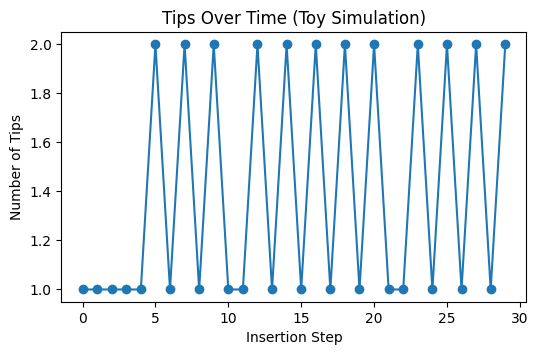

In [6]:

tips_series = DAGLedgerSim().tips_over_time()

plt.figure(figsize=(6,3.5))
plt.plot(range(len(tips_series)), tips_series, marker='o')
plt.xlabel("Insertion Step")
plt.ylabel("Number of Tips")
plt.title("Tips Over Time (Toy Simulation)")
plt.show()



### Is the Ledger Still Acyclic?
Even though each new transaction points to prior ones, it’s good to confirm we didn’t accidentally create a cycle.


In [7]:

# Check acyclicity by ensuring no forward edges point to the future (by time) and doing a DFS visit order check
def ledger_has_cycle(ledger: DAGLedgerSim):
    color = {}
    for tx_id in ledger.transactions:
        color[tx_id] = 0
    
    def dfs(u):
        color[u] = 1
        for v in ledger.children[u]:
            if color[v] == 1:
                return True
            if color[v] == 0 and dfs(v):
                return True
        color[u] = 2
        return False
    
    for u in ledger.transactions:
        if color[u] == 0:
            if dfs(u):
                return True
    return False

print("Cycle present in ledger?", ledger_has_cycle(ledger))


Cycle present in ledger? False
